# GTHA housing market database
# OSEMN methodology Step 2: Scrub
# Step 2.4 encode outliers and major land use types in the Teranet dataset

---

This notebook describes Step 2.4 (part of _Step 2: Scrub_ of OSEMN methodology) performed on the Teranet dataset.
## Overview
### Mark outliers based on `price_to_med_xy` and `price_to_med_year`
Outliers are market by comparing price with medians for xy coordinate pair and for each year.
### New columns produced from `landuse`
One-hot encoded land use codes for major land uses are added to each Teranet records. In addition, all the values are combined into a single categorical column `landuse_class`. Only major land uses are encoded, the rest are represented by the value `Other`.

### Previous steps included: 

* **Step 2.1:** spatial join between the Teranet points and the polygons of GTHA Dissemination Areas (DAs)
    
    * During step 2.1, Teranet records whose coordinates fall outside of the GTHA boundary (as defined by the DA geometry) have been filtered out (6,803,691 of the original 9,039,241 Teranet records remain in the dataset)
     
    * In addition to that, three new columns (`OBJECTID`, `DAUID`, and `CSDNAME`) derived from DA attributes have been added to each Teranet transaction

    * for details, see `notebooks/2.scrub/2.1_teranet_gtha_spatial_join.ipynb`

* **Step 2.2:** correction for consistency of the Teranet records

    * column names were converted to lower case
    
    * inconsistent capitalizations were fixed for columns
    
        * `municipality`    
        * `street_name`
        * `street_designation`
        * `postal_code` (did not show problems, converted as a preventive measure)
        
    * columns `province` and `street_suffix` were removed from the dataset
    
    * new column `street_name_raw` was created: reserve copy of unmodified `street_name`
    
    * column `street_name` was parsed and cleaned for:
    
        * `postal_code`
        * `unitno`
        * `street_number`
        * `street_direction`
        * `street_designation`
        
    * plots of the count and percentage of missing values per column were produced
    
    * inconsistent entries were fixed in the following columns:
        
        * `street_direction`
        * `street_designation`
        * `municipality`
        * `street_name`
        * `unitno`
        
    * for details, see `notebooks/2.scrub/2.2_teranet_consistency.ipynb`

---

For description of OSEMN methodology, see `methodology/0.osemn/osemn.pdf`.

For background information, description of the Teranet dataset, and its attributes, see `methodology/1.obtain/obtain.pdf`.

For description of _Step 2: Scrub_ of OSEMN methodology, see `methodology/2.scrub/scrub.pdf`.

For description of the cleanup plan for the Teranet dataset, see `methodology/2.scrub/teranet_cleanup_plan.pdf`.

For description of Step 2.1 of the cleanup process, see `notebooks/2.scrub/2.1_teranet_gtha_spatial_join.ipynb`.

For description of Step 2.2 of the cleanup process, see `notebooks/2.scrub/2.2_teranet_consistency.ipynb`.

## Import dependencies

In [1]:
random_state = 1

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from time import time

sns.set()

In [3]:
import sys

sys.path.append('../../src')

from io_utils import df_from_csv
from plot_utils import plot_hist
from model_utils import fit_model

## Load Teranet data

In [4]:
data_path = '../../data/'
teranet_path = data_path + 'teranet/'
os.listdir(teranet_path)

['1.1_Teranet_DA.csv',
 '1.3_Teranet_DA_TAZ_PG_FSA.csv',
 '4_Teranet_lu_predict_3c.csv',
 '2_Teranet_consistent.csv',
 'parcel16_epoi13.csv',
 '1.2_Teranet_DA_TAZ.csv',
 '1.4_Teranet_DA_TAZ_FSA_LU_LUDMTI.csv',
 '1.4_Teranet_DA_TAZ_FSA_LU.csv',
 '4_Teranet_lu_predict_4c.csv',
 '.ipynb_checkpoints',
 'ParcelLandUse.zip',
 'ParcelLandUse',
 'HHSaleHistory.csv',
 '3_Teranet_nonan_new_cols.csv',
 'GTAjoinedLanduseSales']

In [5]:
df = df_from_csv(teranet_path + '3_Teranet_nonan_new_cols.csv', parse_dates=['registration_date'])

----- DataFrame loaded
in 65.69 seconds
with 5,188,513 rows
and 55 columns
-- Column names:
 Index(['transaction_id', 'lro_num', 'pin', 'consideration_amt',
       'registration_date', 'postal_code', 'unitno', 'street_name',
       'street_designation', 'street_direction', 'municipality',
       'street_number', 'x', 'y', 'dauid', 'csduid', 'csdname', 'taz_o', 'fsa',
       'pca_id', 'postal_code_dmti', 'pin_lu', 'landuse', 'prop_code',
       'dmti_lu', 'street_name_raw', 'year', 'year_month', 'year3',
       'census_year', 'census2001_year', 'tts_year', 'tts1991_year', 'xy',
       'pin_total_sales', 'xy_total_sales', 'pin_prev_sales', 'xy_prev_sales',
       'xy_first_sale', 'pin_years_since_last_sale',
       'xy_years_since_last_sale', 'xy_years_to_next_sale',
       'da_days_since_last_sale', 'da_years_since_last_sale',
       'xy_sale_next_6m', 'price_2016', 'pin_price_cum_sum',
       'xy_price_cum_sum', 'pin_price_pct_change', 'xy_price_pct_change',
       'price_da_pct_change

In [6]:
df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5188513 entries, 0 to 5188512
Data columns (total 55 columns):
transaction_id               5188513 non-null int64
lro_num                      5188513 non-null int64
pin                          5188513 non-null int64
consideration_amt            5188513 non-null float64
registration_date            5188513 non-null datetime64[ns]
postal_code                  4881914 non-null object
unitno                       1332616 non-null object
street_name                  5144061 non-null object
street_designation           5090453 non-null object
street_direction             550657 non-null object
municipality                 5187161 non-null object
street_number                5142790 non-null object
x                            5188513 non-null float64
y                            5188513 non-null float64
dauid                        5188513 non-null int64
csduid                       5188513 non-null int64
csdname                      51885

## Mark top outliers based on `price_to_med_xy` and `price_to_med_year`
Outliers with high transaction volumes are marked with a boolean variable `outlier` in the following cases:
* if their value of `price_to_med_year` is greater than 5
* if their value of `price_to_med_xy` is greater that 2.5 (5 standard deviations above the mean)

### Based on `price_to_med_year`

In [7]:
# set criteria for outliers
max_price = 3
mask1 = df['price_to_med_year'] > max_price
suf = 'y_'

# mark outliers
df.loc[mask1, 'outlier_' + suf + str(max_price)] = True
df['outlier_' + suf + str(max_price)] = df['outlier_' + suf + str(max_price)].fillna(False)
print("New column `outlier_{0}{1}` was added to the DataFrame.".format(suf, max_price))

print('Mean price of all records that are marked as outliers: {0:,.2f}'
      .format(df.query('{0} == True'.format('outlier_' + suf + str(max_price)))['price_2016'].mean()))
print('Mean price of all records that are not marked as outliers: {0:,.2f}'
      .format(df.query('{0} == False'.format('outlier_' + suf + str(max_price)))['price_2016'].mean()))
df['outlier_' + suf + str(max_price)].value_counts()

New column `outlier_y_3` was added to the DataFrame.
Mean price of all records that are marked as outliers: 9,201,028.01
Mean price of all records that are not marked as outliers: 355,344.18


False    4936976
True      251537
Name: outlier_y_3, dtype: int64

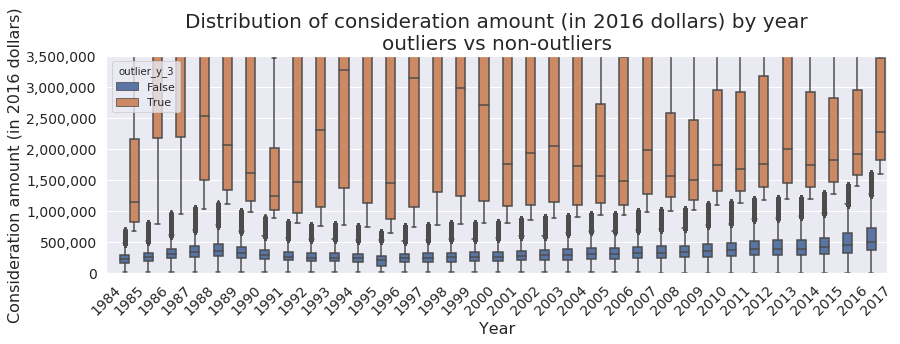

In [8]:
f, ax = plt.subplots(1, figsize=(14, 4))
sns.boxplot(data=df, x='year', y='price_2016', hue='outlier_' + suf + str(max_price), ax=ax)
ax.set_xlim(107, 140.5)
ax.set_ylim(0, 3500000)
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)
ax.set_ylabel("Consideration amount (in 2016 dollars)", fontsize=16)
ax.set_xlabel("Year", fontsize=16)
ax.set_title("Distribution of consideration amount (in 2016 dollars) by year"
             "\noutliers vs non-outliers", fontsize=20)
ax.get_yaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.show()

In [9]:
# set criteria for outliers
max_price = 5
mask1 = df['price_to_med_year'] > max_price
suf = 'y_'

# mark outliers
df.loc[mask1, 'outlier_' + suf + str(max_price)] = True
df['outlier_' + suf + str(max_price)] = df['outlier_' + suf + str(max_price)].fillna(False)
print("New column `outlier_{0}{1}` was added to the DataFrame.".format(suf, max_price))

print('Mean price of all records that are marked as outliers: {0:,.2f}'
      .format(df.query('{0} == True'.format('outlier_' + suf + str(max_price)))['price_2016'].mean()))
print('Mean price of all records that are not marked as outliers: {0:,.2f}'
      .format(df.query('{0} == False'.format('outlier_' + suf + str(max_price)))['price_2016'].mean()))
df['outlier_' + suf + str(max_price)].value_counts()

New column `outlier_y_5` was added to the DataFrame.
Mean price of all records that are marked as outliers: 15,712,333.55
Mean price of all records that are not marked as outliers: 376,902.10


False    5050699
True      137814
Name: outlier_y_5, dtype: int64

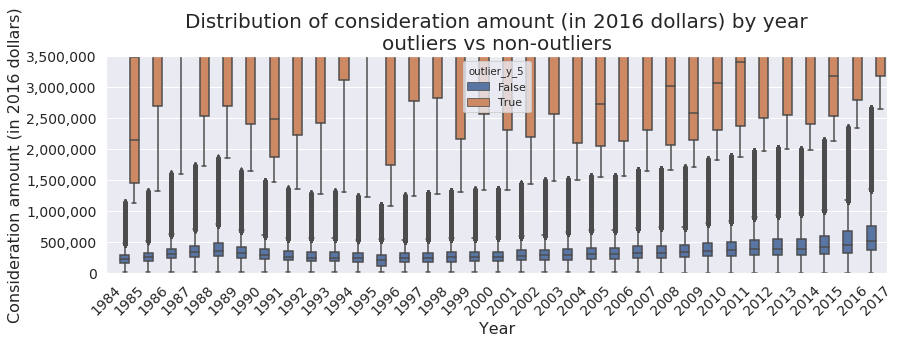

In [10]:
f, ax = plt.subplots(1, figsize=(14, 4))
sns.boxplot(data=df, x='year', y='price_2016', hue='outlier_' + suf + str(max_price), ax=ax)
ax.set_xlim(107, 140.5)
ax.set_ylim(0, 3500000)
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)
ax.set_ylabel("Consideration amount (in 2016 dollars)", fontsize=16)
ax.set_xlabel("Year", fontsize=16)
ax.set_title("Distribution of consideration amount (in 2016 dollars) by year"
             "\noutliers vs non-outliers", fontsize=20)
ax.get_yaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.show()

In [11]:
# set criteria for outliers
max_price = 10
mask1 = df['price_to_med_year'] > max_price
suf = 'y_'

# mark outliers
df.loc[mask1, 'outlier_' + suf + str(max_price)] = True
df['outlier_' + suf + str(max_price)] = df['outlier_' + suf + str(max_price)].fillna(False)
print("New column `outlier_{0}{1}` was added to the DataFrame.".format(suf, max_price))

print('Mean price of all records that are marked as outliers: {0:,.2f}'
      .format(df.query('{0} == True'.format('outlier_' + suf + str(max_price)))['price_2016'].mean()))
print('Mean price of all records that are not marked as outliers: {0:,.2f}'
      .format(df.query('{0} == False'.format('outlier_' + suf + str(max_price)))['price_2016'].mean()))
df['outlier_' + suf + str(max_price)].value_counts()

New column `outlier_y_10` was added to the DataFrame.
Mean price of all records that are marked as outliers: 24,227,469.69
Mean price of all records that are not marked as outliers: 397,286.53


False    5104253
True       84260
Name: outlier_y_10, dtype: int64

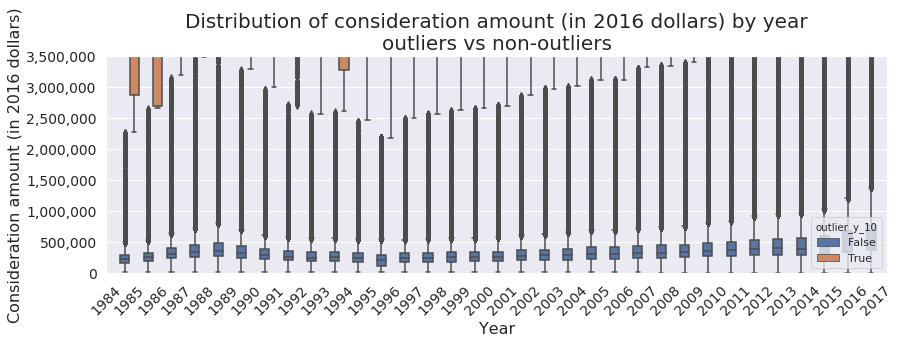

In [12]:
f, ax = plt.subplots(1, figsize=(14, 4))
sns.boxplot(data=df, x='year', y='price_2016', hue='outlier_' + suf + str(max_price), ax=ax)
ax.set_xlim(107, 140.5)
ax.set_ylim(0, 3500000)
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)
ax.set_ylabel("Consideration amount (in 2016 dollars)", fontsize=16)
ax.set_xlabel("Year", fontsize=16)
ax.set_title("Distribution of consideration amount (in 2016 dollars) by year"
             "\noutliers vs non-outliers", fontsize=20)
ax.get_yaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.show()

In [13]:
# set criteria for outliers
max_price = 20
mask1 = df['price_to_med_year'] > max_price
suf = 'y_'

# mark outliers
df.loc[mask1, 'outlier_' + suf + str(max_price)] = True
df['outlier_' + suf + str(max_price)] = df['outlier_' + suf + str(max_price)].fillna(False)
print("New column `outlier_{0}{1}` was added to the DataFrame.".format(suf, max_price))

print('Mean price of all records that are marked as outliers: {0:,.2f}'
      .format(df.query('{0} == True'.format('outlier_' + suf + str(max_price)))['price_2016'].mean()))
print('Mean price of all records that are not marked as outliers: {0:,.2f}'
      .format(df.query('{0} == False'.format('outlier_' + suf + str(max_price)))['price_2016'].mean()))
df['outlier_' + suf + str(max_price)].value_counts()

New column `outlier_y_20` was added to the DataFrame.
Mean price of all records that are marked as outliers: 35,400,277.03
Mean price of all records that are not marked as outliers: 421,195.46


False    5134647
True       53866
Name: outlier_y_20, dtype: int64

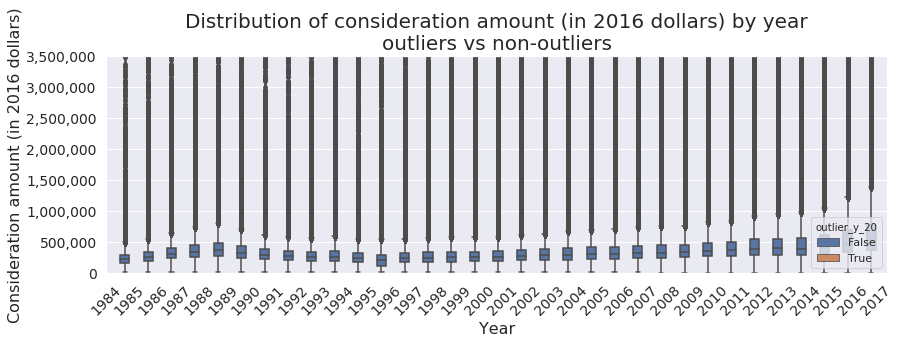

In [14]:
f, ax = plt.subplots(1, figsize=(14, 4))
sns.boxplot(data=df, x='year', y='price_2016', hue='outlier_' + suf + str(max_price), ax=ax)
ax.set_xlim(107, 140.5)
ax.set_ylim(0, 3500000)
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)
ax.set_ylabel("Consideration amount (in 2016 dollars)", fontsize=16)
ax.set_xlabel("Year", fontsize=16)
ax.set_title("Distribution of consideration amount (in 2016 dollars) by year"
             "\noutliers vs non-outliers", fontsize=20)
ax.get_yaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.show()

### Based on `price_to_med_xy`

In [15]:
# set criteria for outliers
max_price = 2
mask1 = df['price_to_med_xy'] > max_price
suf = 'xy_'

# mark outliers
df.loc[mask1, 'outlier_' + suf + str(max_price)] = True
df['outlier_' + suf + str(max_price)] = df['outlier_' + suf + str(max_price)].fillna(False)
print("New column `outlier_{0}{1}` was added to the DataFrame.".format(suf, max_price))

print('Mean price of all records that are marked as outliers: {0:,.2f}'
      .format(df.query('{0} == True'.format('outlier_' + suf + str(max_price)))['price_2016'].mean()))
print('Mean price of all records that are not marked as outliers: {0:,.2f}'
      .format(df.query('{0} == False'.format('outlier_' + suf + str(max_price)))['price_2016'].mean()))
df['outlier_' + suf + str(max_price)].value_counts()

New column `outlier_xy_2` was added to the DataFrame.
Mean price of all records that are marked as outliers: 8,386,852.25
Mean price of all records that are not marked as outliers: 541,711.36


False    5027851
True      160662
Name: outlier_xy_2, dtype: int64

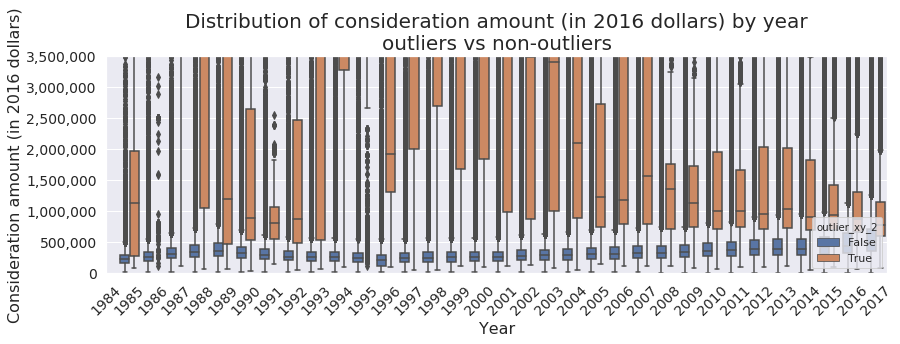

In [16]:
f, ax = plt.subplots(1, figsize=(14, 4))
sns.boxplot(data=df, x='year', y='price_2016', hue='outlier_' + suf + str(max_price), ax=ax)
ax.set_xlim(107, 140.5)
ax.set_ylim(0, 3500000)
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)
ax.set_ylabel("Consideration amount (in 2016 dollars)", fontsize=16)
ax.set_xlabel("Year", fontsize=16)
ax.set_title("Distribution of consideration amount (in 2016 dollars) by year"
             "\noutliers vs non-outliers", fontsize=20)
ax.get_yaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.show()

In [17]:
# set criteria for outliers
max_price = 4
mask1 = df['price_to_med_xy'] > max_price
suf = 'xy_'

# mark outliers
df.loc[mask1, 'outlier_' + suf + str(max_price)] = True
df['outlier_' + suf + str(max_price)] = df['outlier_' + suf + str(max_price)].fillna(False)
print("New column `outlier_{0}{1}` was added to the DataFrame.".format(suf, max_price))

print('Mean price of all records that are marked as outliers: {0:,.2f}'
      .format(df.query('{0} == True'.format('outlier_' + suf + str(max_price)))['price_2016'].mean()))
print('Mean price of all records that are not marked as outliers: {0:,.2f}'
      .format(df.query('{0} == False'.format('outlier_' + suf + str(max_price)))['price_2016'].mean()))
df['outlier_' + suf + str(max_price)].value_counts()

New column `outlier_xy_4` was added to the DataFrame.
Mean price of all records that are marked as outliers: 20,927,334.31
Mean price of all records that are not marked as outliers: 557,893.36


False    5130747
True       57766
Name: outlier_xy_4, dtype: int64

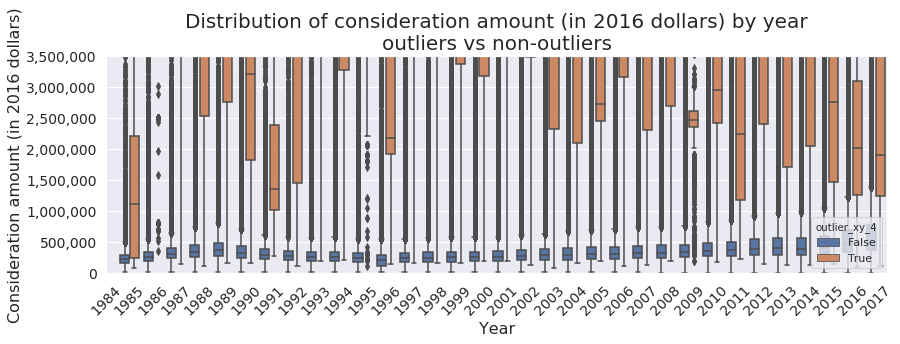

In [18]:
f, ax = plt.subplots(1, figsize=(14, 4))
sns.boxplot(data=df, x='year', y='price_2016', hue='outlier_' + suf + str(max_price), ax=ax)
ax.set_xlim(107, 140.5)
ax.set_ylim(0, 3500000)
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)
ax.set_ylabel("Consideration amount (in 2016 dollars)", fontsize=16)
ax.set_xlabel("Year", fontsize=16)
ax.set_title("Distribution of consideration amount (in 2016 dollars) by year"
             "\noutliers vs non-outliers", fontsize=20)
ax.get_yaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.show()

In [19]:
# set criteria for outliers
max_price = 10
mask1 = df['price_to_med_xy'] > max_price
suf = 'xy_'

# mark outliers
df.loc[mask1, 'outlier_' + suf + str(max_price)] = True
df['outlier_' + suf + str(max_price)] = df['outlier_' + suf + str(max_price)].fillna(False)
print("New column `outlier_{0}{1}` was added to the DataFrame.".format(suf, max_price))

print('Mean price of all records that are marked as outliers: {0:,.2f}'
      .format(df.query('{0} == True'.format('outlier_' + suf + str(max_price)))['price_2016'].mean()))
print('Mean price of all records that are not marked as outliers: {0:,.2f}'
      .format(df.query('{0} == False'.format('outlier_' + suf + str(max_price)))['price_2016'].mean()))
df['outlier_' + suf + str(max_price)].value_counts()

New column `outlier_xy_10` was added to the DataFrame.
Mean price of all records that are marked as outliers: 31,470,942.38
Mean price of all records that are not marked as outliers: 571,639.20


False    5152735
True       35778
Name: outlier_xy_10, dtype: int64

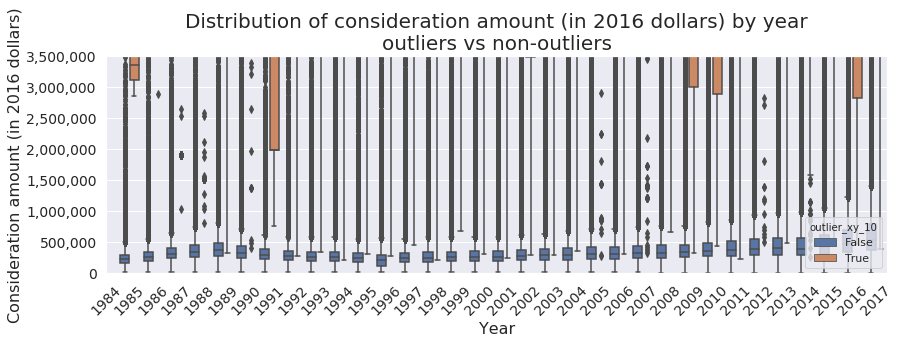

In [20]:
f, ax = plt.subplots(1, figsize=(14, 4))
sns.boxplot(data=df, x='year', y='price_2016', hue='outlier_' + suf + str(max_price), ax=ax)
ax.set_xlim(107, 140.5)
ax.set_ylim(0, 3500000)
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)
ax.set_ylabel("Consideration amount (in 2016 dollars)", fontsize=16)
ax.set_xlabel("Year", fontsize=16)
ax.set_title("Distribution of consideration amount (in 2016 dollars) by year"
             "\noutliers vs non-outliers", fontsize=20)
ax.get_yaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.show()

### Outlier categories and counts of records that they produced

In [21]:
mask1 = df.columns.str.contains('outlier')
outlier_cols = df.columns[mask1]
df[outlier_cols].sum()

outlier_y_3      251537
outlier_y_5      137814
outlier_y_10      84260
outlier_y_20      53866
outlier_xy_2     160662
outlier_xy_4      57766
outlier_xy_10     35778
dtype: int64

## Add column `lu_code`: join land use codes for GTA
Hamilton land use codes have been converted to match GTA codes in step 2.1.4.

### Read land use codes for GTA used by geography department

In [22]:
landuse_code_path = teranet_path + 'ParcelLandUse/GTA/'
os.listdir(landuse_code_path)

['GTA_land_use_code.txt',
 'GTAparcel16LU12.shx',
 'with_epoi',
 'GTAparcel16LU12.prj',
 'gta_land_use_code.csv',
 'GTAparcel16LU12.cpg',
 'GTAparcel16LU12.shp',
 'GTAparcel16LU12.dbf']

In [23]:
land_use_codes = pd.read_csv(landuse_code_path + 'gta_land_use_code.csv')
land_use_codes.head()

,landuse,code
0,0,Uncoded
1,1,Single Detached House
2,2,Commercial/Shopping
3,3,Industrial/Employment Lands
4,4,Government/Institutional


### Join land use codes to Teranet records

In [24]:
# join GTA land use codes
df = pd.merge(df, land_use_codes, how='left',
              left_on='landuse', right_on='landuse')
print("GTA land use codes were joined to the DataFrame.")
df['code'].value_counts().head(10)

GTA land use codes were joined to the DataFrame.


Single Detached House                          2189784
Apartments/Condos/Residence                    1102936
Strata Townhouses                               313918
Duplex/Semi-Detached                            244329
Townhouse                                       178585
Mix(Commercial Residential)                     167410
Underdeveloped Land                             153307
Mixed Complex (Residential, Office, Retail)     112398
Industrial/Employment Lands                     106056
Commercial/Shopping                             102172
Name: code, dtype: int64

## One-hot encode top 10 land uses by frequency
Top 10 land uses by count of Teranet records are one-hot (binary) encoded into separate variables.

In [25]:
outlier_col = 'outlier_y_10'

### Single Detached House
#### Set selection criteria and display distributions of price and count of records per xy coordinate pair

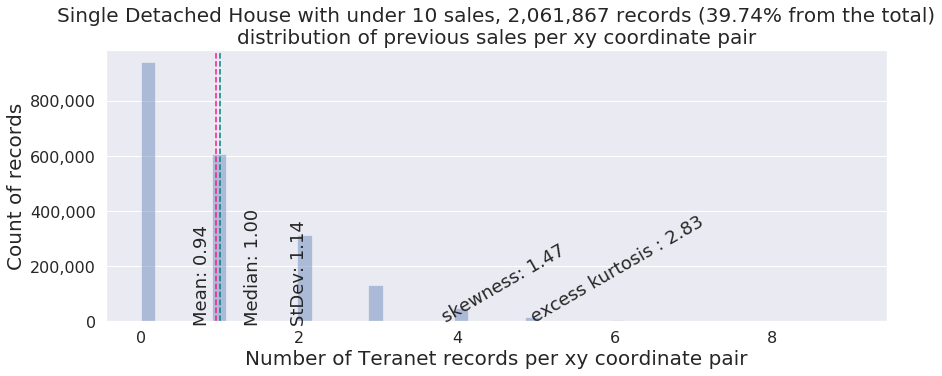

In [26]:
lu_type = 'Single Detached House'
max_sales = 10
mask1 = df['code'] == lu_type
mask2 = df['xy_prev_sales'] < max_sales
mask3 = df[outlier_col] == False
s = df[mask1 & mask2 & mask3]

plot_hist(s['xy_prev_sales'], form_y=True, 
          title="{0} with under {1} sales, {2:,} records ({3:.2f}% from the total)"
          .format(lu_type, max_sales, len(s), len(s) / len(df) * 100) + \
          "\ndistribution of previous sales per xy coordinate pair",
          x_label="Number of Teranet records per xy coordinate pair", 
          mean_xlift=0.7, med_xlift=1.3, sdev_xlift=2)

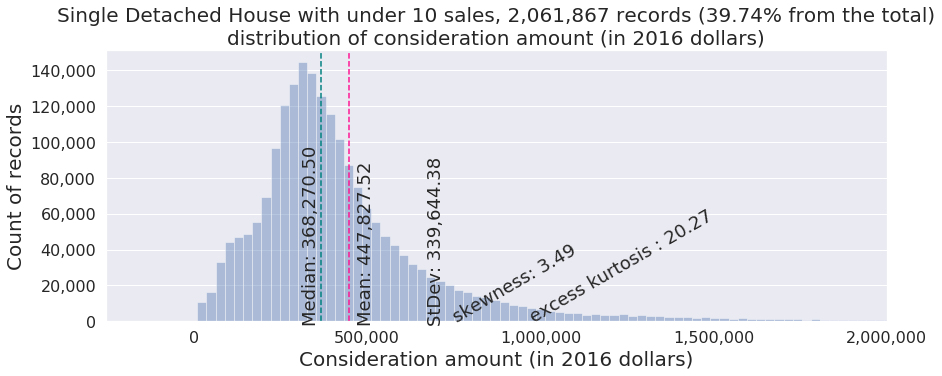

In [27]:
plot_hist(s['price_2016'].dropna(), form_y=True, form_x=True,
          title="{0} with under {1} sales, {2:,} records ({3:.2f}% from the total)"
          .format(lu_type, max_sales, len(s), len(s) / len(df) * 100) + \
          "\ndistribution of consideration amount (in 2016 dollars)",
          x_label="Consideration amount (in 2016 dollars)", 
          mean_xlift=1.05, med_xlift=0.85, sdev_xlift=1.5, skew_xlift=1.1, max_x=2000000, bins=200)

#### Add new binary variable and new class to `lu_class`

In [28]:
df.loc[mask1 & mask2 & mask3, 'lu_class'] = lu_type
df.loc[mask1 & mask2 & mask3, 'luc_detached'] = True
df['luc_detached'] = df['luc_detached'].fillna(False)
df['luc_detached'].value_counts()

False    3126646
True     2061867
Name: luc_detached, dtype: int64

### Apartments/condos/residence
#### Set selection criteria and display distributions of price and count of records per xy coordinate pair

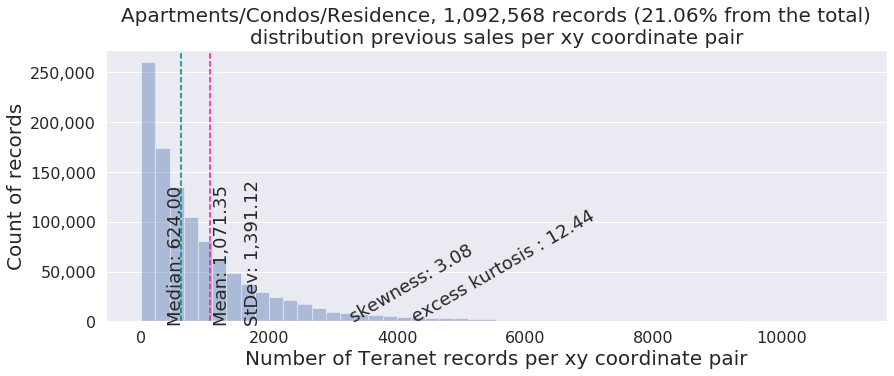

In [29]:
lu_type = 'Apartments/Condos/Residence'
mask1 = df['code'] == lu_type
mask2 = df[outlier_col] == False
s = df[mask1 & mask2]

plot_hist(s['xy_prev_sales'], form_y=True, 
          title="{0}, {1:,} records ({2:.2f}% from the total)".format(lu_type, len(s), len(s) / len(df) * 100) + \
                "\ndistribution previous sales per xy coordinate pair",
          x_label="Number of Teranet records per xy coordinate pair", mean_xlift=1.05, med_xlift=0.65, sdev_xlift=1.5)

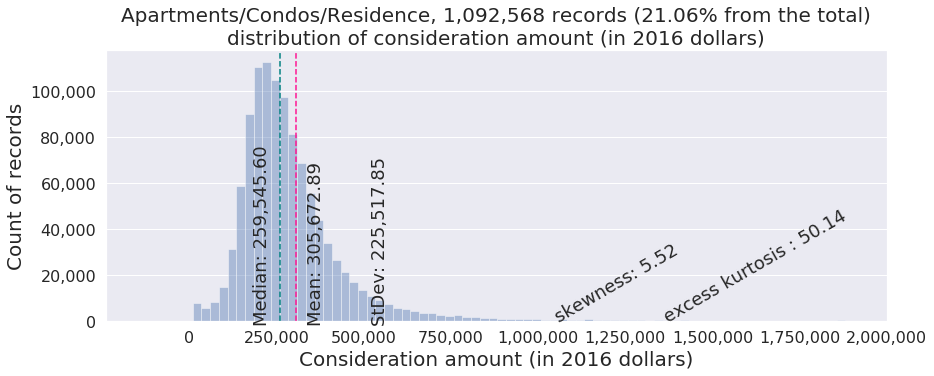

In [30]:
plot_hist(s['price_2016'].dropna(), form_y=True, form_x=True,
          title="{0}, {1:,} records ({2:.2f}% from the total)".format(lu_type, len(s), len(s) / len(df) * 100) + \
                "\ndistribution of consideration amount (in 2016 dollars)",
          x_label="Consideration amount (in 2016 dollars)", mean_xlift=1.1, med_xlift=0.7, sdev_xlift=1.7,
          max_x=2000000, bins=200)

#### Add new binary variable and new class to `lu_class`

In [31]:
df.loc[mask1 & mask2, 'lu_class'] = lu_type
df.loc[mask1 & mask2, 'luc_condo'] = True
df['luc_condo'] = df['luc_condo'].fillna(False)
df['luc_condo'].value_counts()

False    4095945
True     1092568
Name: luc_condo, dtype: int64

### Strata Townhouses
#### Set selection criteria and display distributions of price and count of records per xy coordinate pair

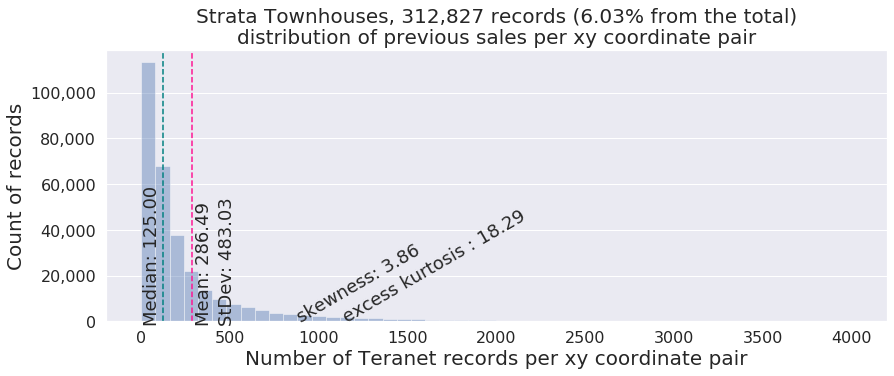

In [32]:
lu_type = 'Strata Townhouses'
mask1 = df['code'] == lu_type
mask2 = df[outlier_col] == False
s = df[mask1 & mask2]

plot_hist(s['xy_prev_sales'], form_y=True, 
          title="{0}, {1:,} records ({2:.2f}% from the total)".format(lu_type, len(s), len(s) / len(df) * 100) + \
                "\ndistribution of previous sales per xy coordinate pair",
          x_label="Number of Teranet records per xy coordinate pair", mean_xlift=1.05, med_xlift=0.1, sdev_xlift=1.5)

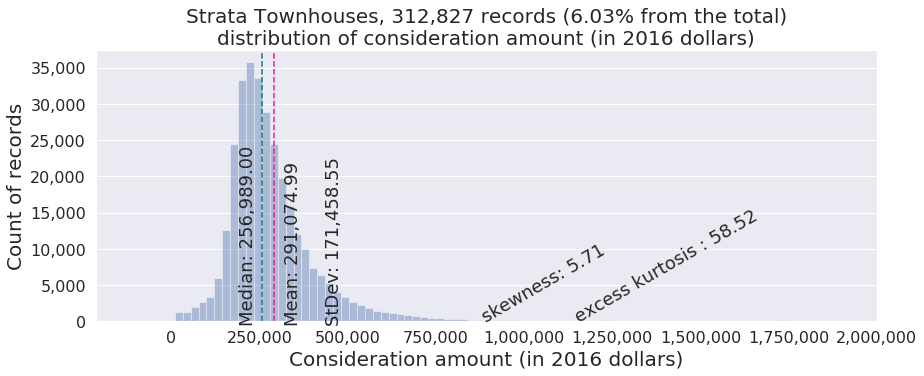

In [33]:
plot_hist(s['price_2016'].dropna(), form_y=True, form_x=True,
          title="{0}, {1:,} records ({2:.2f}% from the total)".format(lu_type, len(s), len(s) / len(df) * 100) + \
          "\ndistribution of consideration amount (in 2016 dollars)",
          x_label="Consideration amount (in 2016 dollars)", mean_xlift=1.1, med_xlift=0.75, sdev_xlift=1.5,
          max_x=2000000, bins=200)

#### Add new binary variable and new class to `lu_class`

In [34]:
df.loc[mask1 & mask2, 'lu_class'] = lu_type
df.loc[mask1 & mask2, 'luc_strata'] = True
df['luc_strata'] = df['luc_strata'].fillna(False)
df['luc_strata'].value_counts()

False    4875686
True      312827
Name: luc_strata, dtype: int64

### Duplex/Semi-Detached
#### Set selection criteria and display distributions of price and count of records per xy coordinate pair

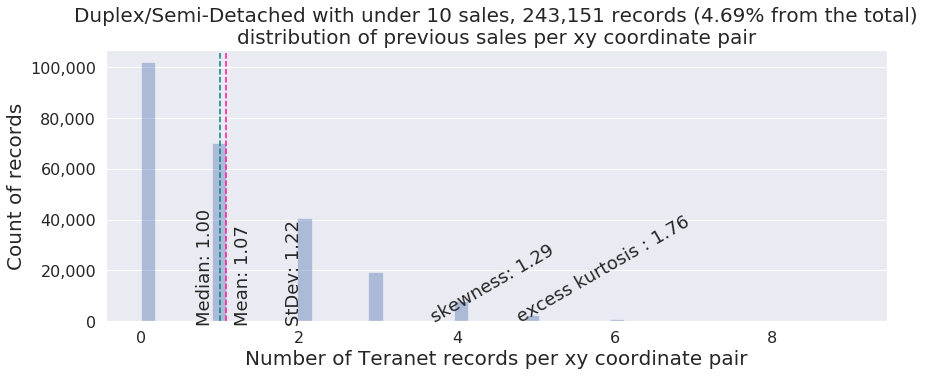

In [35]:
lu_type = 'Duplex/Semi-Detached'
max_sales = 10
mask1 = df['code'] == lu_type
mask2 = df['xy_prev_sales'] < max_sales
mask3 = df[outlier_col] == False
s = df[mask1 & mask2 & mask3]

plot_hist(s['xy_prev_sales'], form_y=True, 
          title="{0} with under {1} sales, {2:,} records ({3:.2f}% from the total)"
          .format(lu_type, max_sales, len(s), len(s) / len(df) * 100) + \
          "\ndistribution of previous sales per xy coordinate pair",
          x_label="Number of Teranet records per xy coordinate pair", 
          mean_xlift=1.1, med_xlift=0.7, sdev_xlift=1.7)

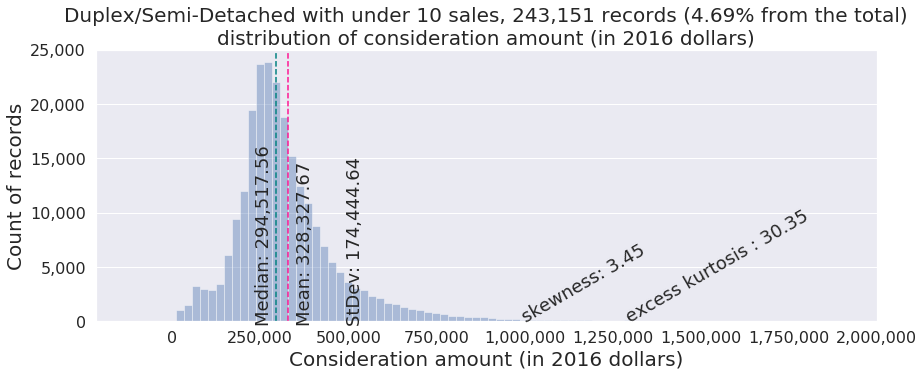

In [36]:
plot_hist(s['price_2016'].dropna(), form_y=True, form_x=True,
          title="{0} with under {1} sales, {2:,} records ({3:.2f}% from the total)"
          .format(lu_type, max_sales, len(s), len(s) / len(df) * 100) + \
          "\ndistribution of consideration amount (in 2016 dollars)",
          x_label="Consideration amount (in 2016 dollars)", 
          mean_xlift=1.07, med_xlift=0.8, sdev_xlift=1.5, max_x=2000000, bins=200)

#### Add new binary variable and new class to `lu_class`

In [37]:
df.loc[mask1 & mask2 & mask3, 'lu_class'] = lu_type
df.loc[mask1 & mask2 & mask3, 'luc_duplex'] = True
df['luc_duplex'] = df['luc_duplex'].fillna(False)
df['luc_duplex'].value_counts()

False    4945362
True      243151
Name: luc_duplex, dtype: int64

### Townhouse
#### Set selection criteria and display distributions of price and count of records per xy coordinate pair

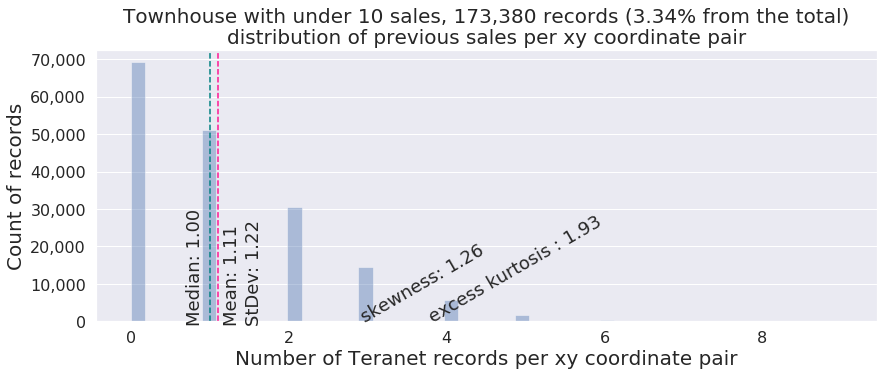

In [38]:
lu_type = 'Townhouse'
max_sales = 10
mask1 = df['code'] == lu_type
mask2 = df['xy_prev_sales'] < max_sales
mask3 = df[outlier_col] == False
s = df[mask1 & mask2 & mask3]

plot_hist(s['xy_prev_sales'], form_y=True, 
          title="{0} with under {1} sales, {2:,} records ({3:.2f}% from the total)"
          .format(lu_type, max_sales, len(s), len(s) / len(df) * 100) + \
          "\ndistribution of previous sales per xy coordinate pair",
          x_label="Number of Teranet records per xy coordinate pair", 
          mean_xlift=1.05, med_xlift=0.7, sdev_xlift=1.3)

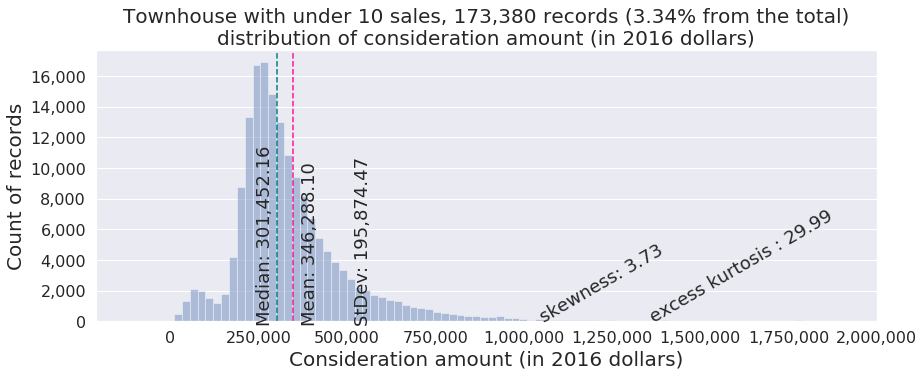

In [39]:
plot_hist(s['price_2016'].dropna(), form_y=True, form_x=True,
          title="{0} with under {1} sales, {2:,} records ({3:.2f}% from the total)"
          .format(lu_type, max_sales, len(s), len(s) / len(df) * 100) + \
          "\ndistribution of consideration amount (in 2016 dollars)",
          x_label="Consideration amount (in 2016 dollars)", 
          mean_xlift=1.07, med_xlift=0.8, sdev_xlift=1.5, max_x=2000000, bins=200)

#### Add new binary variable and new class to `lu_class`

In [40]:
df.loc[mask1 & mask2 & mask3, 'lu_class'] = lu_type
df.loc[mask1 & mask2 & mask3, 'luc_townhouse'] = True
df['luc_townhouse'] = df['luc_townhouse'].fillna(False)
df['luc_townhouse'].value_counts()

False    5015133
True      173380
Name: luc_townhouse, dtype: int64

### Mix(Commercial Residential)
#### Set selection criteria and display distributions of price and count of records per xy coordinate pair

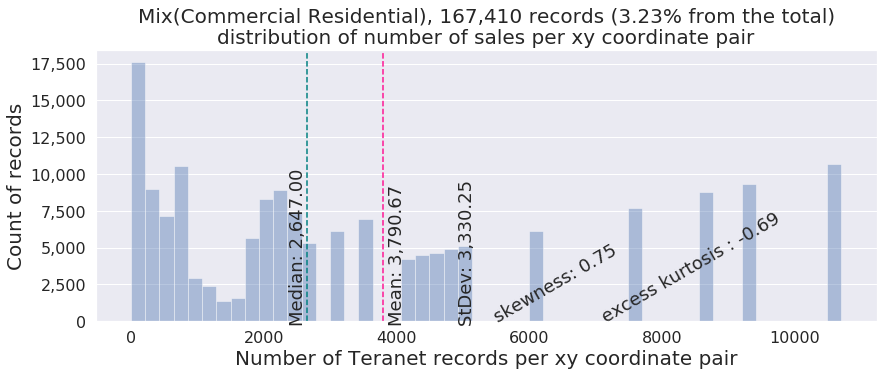

In [41]:
lu_type = 'Mix(Commercial Residential)'
mask1 = df['code'] == lu_type
s = df[mask1]

plot_hist(s['xy_total_sales'], form_y=True, 
          title="{0}, {1:,} records ({2:.2f}% from the total)"
          .format(lu_type, len(s), len(s) / len(df) * 100) + \
          "\ndistribution of number of sales per xy coordinate pair",
          x_label="Number of Teranet records per xy coordinate pair", 
          mean_xlift=1.02, med_xlift=0.9, sdev_xlift=1.3, skew_xlift=1.1)

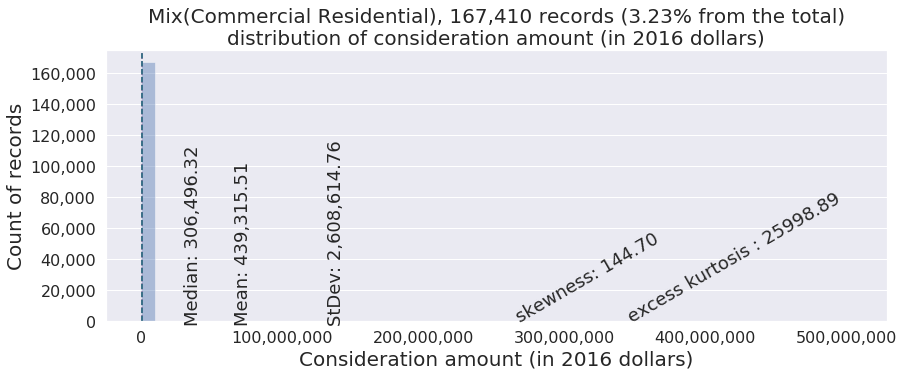

In [42]:
plot_hist(s['price_2016'].dropna(), form_y=True, form_x=True,
          title="{0}, {1:,} records ({2:.2f}% from the total)"
          .format(lu_type, len(s), len(s) / len(df) * 100) + \
          "\ndistribution of consideration amount (in 2016 dollars)",
          x_label="Consideration amount (in 2016 dollars)", 
          mean_xlift=150, med_xlift=100, sdev_xlift=300)

#### Add new binary variable and new class to `lu_class`

In [43]:
df.loc[mask1, 'lu_class'] = lu_type
df.loc[mask1, 'luc_mixuse'] = True
df['luc_mixuse'] = df['luc_mixuse'].fillna(False)
df['luc_mixuse'].value_counts()

False    5021103
True      167410
Name: luc_mixuse, dtype: int64

### Underdeveloped Land
#### Set selection criteria and display distributions of price and count of records per xy coordinate pair

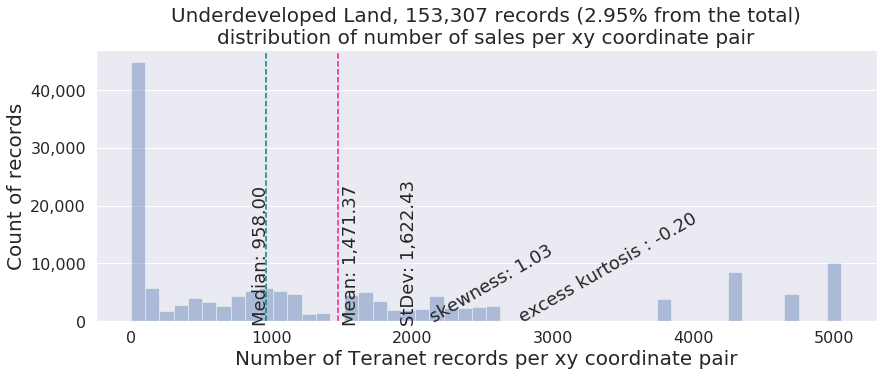

In [44]:
lu_type = 'Underdeveloped Land'
mask1 = df['code'] == lu_type
s = df[mask1]

plot_hist(s['xy_total_sales'], form_y=True, 
          title="{0}, {1:,} records ({2:.2f}% from the total)"
          .format(lu_type, len(s), len(s) / len(df) * 100) + \
          "\ndistribution of number of sales per xy coordinate pair",
          x_label="Number of Teranet records per xy coordinate pair", 
          mean_xlift=1.02, med_xlift=0.9, sdev_xlift=1.3, skew_xlift=1.1)

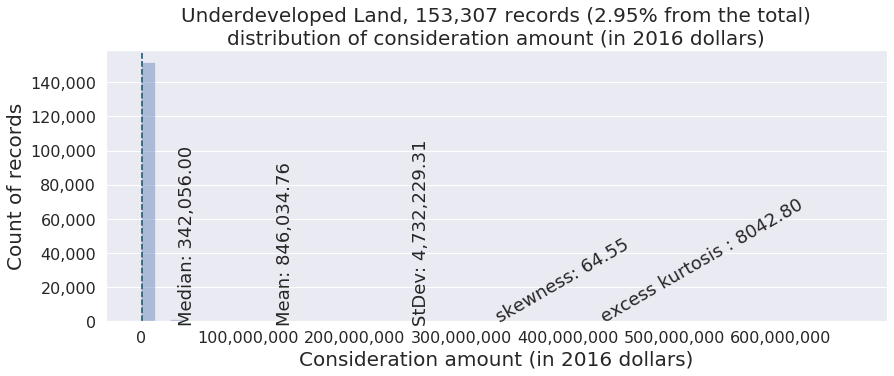

In [45]:
plot_hist(s['price_2016'].dropna(), form_y=True, form_x=True,
          title="{0}, {1:,} records ({2:.2f}% from the total)"
          .format(lu_type, len(s), len(s) / len(df) * 100) + \
          "\ndistribution of consideration amount (in 2016 dollars)",
          x_label="Consideration amount (in 2016 dollars)", 
          mean_xlift=150, med_xlift=100, sdev_xlift=300, skew_xlift=1.3)

#### Add new binary variable and new class to `lu_class`

In [46]:
df.loc[mask1, 'lu_class'] = lu_type
df.loc[mask1, 'luc_underdeveloped'] = True
df['luc_underdeveloped'] = df['luc_underdeveloped'].fillna(False)
df['luc_underdeveloped'].value_counts()

False    5035206
True      153307
Name: luc_underdeveloped, dtype: int64

### Mixed Complex (Residential, Office, Retail)
#### Set selection criteria and display distributions of price and count of records per xy coordinate pair

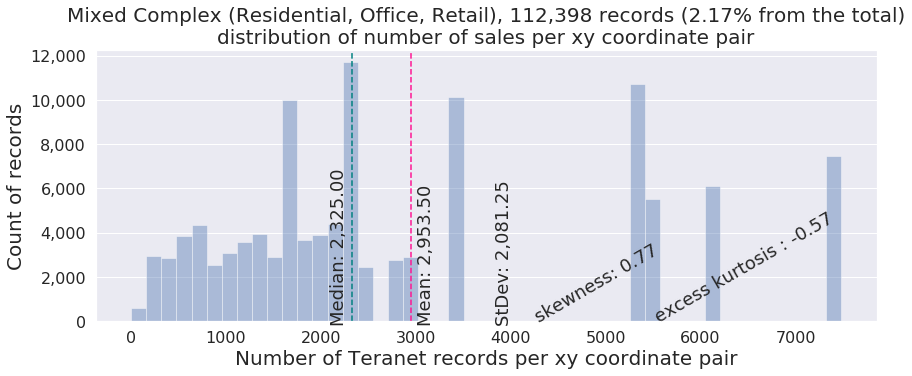

In [47]:
lu_type = 'Mixed Complex (Residential, Office, Retail)'
mask1 = df['code'] == lu_type
s = df[mask1]

plot_hist(s['xy_total_sales'], form_y=True, 
          title="{0}, {1:,} records ({2:.2f}% from the total)"
          .format(lu_type, len(s), len(s) / len(df) * 100) + \
          "\ndistribution of number of sales per xy coordinate pair",
          x_label="Number of Teranet records per xy coordinate pair", 
          mean_xlift=1.02, med_xlift=0.9, sdev_xlift=1.3, skew_xlift=1.1)

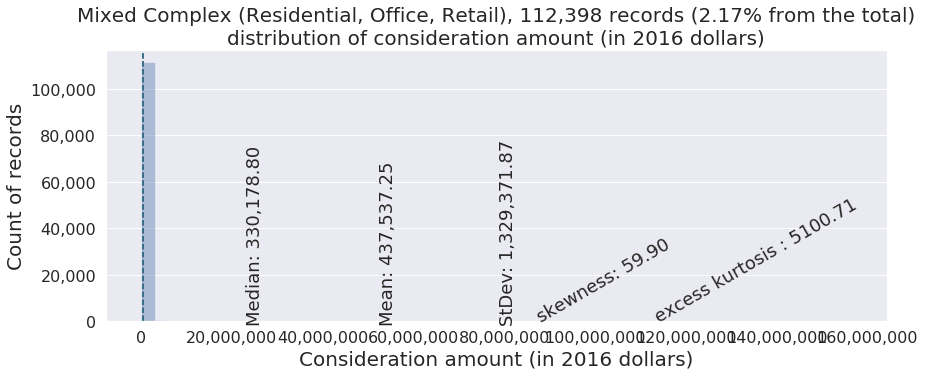

In [48]:
plot_hist(s['price_2016'].dropna(), form_y=True, form_x=True,
          title="{0}, {1:,} records ({2:.2f}% from the total)"
          .format(lu_type, len(s), len(s) / len(df) * 100) + \
          "\ndistribution of consideration amount (in 2016 dollars)",
          x_label="Consideration amount (in 2016 dollars)", 
          mean_xlift=120, med_xlift=70, sdev_xlift=180, skew_xlift=1.1)

#### Add new binary variable and new class to `lu_class`

In [49]:
df.loc[mask1, 'lu_class'] = lu_type
df.loc[mask1, 'luc_mixedcomplex'] = True
df['luc_mixedcomplex'] = df['luc_mixedcomplex'].fillna(False)
df['luc_mixedcomplex'].value_counts()

False    5076115
True      112398
Name: luc_mixedcomplex, dtype: int64

### Industrial/Employment Lands
#### Set selection criteria and display distributions of price and count of records per xy coordinate pair

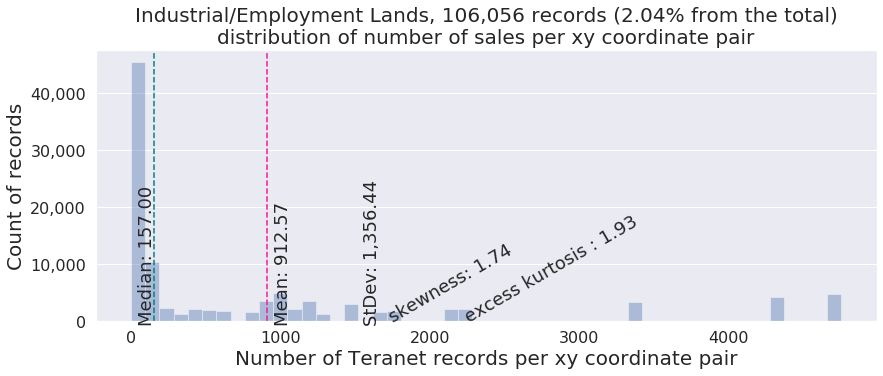

In [50]:
lu_type = 'Industrial/Employment Lands'
mask1 = df['code'] == lu_type
s = df[mask1]

plot_hist(s['xy_total_sales'], form_y=True, 
          title="{0}, {1:,} records ({2:.2f}% from the total)"
          .format(lu_type, len(s), len(s) / len(df) * 100) + \
          "\ndistribution of number of sales per xy coordinate pair",
          x_label="Number of Teranet records per xy coordinate pair", 
          mean_xlift=1.05, med_xlift=0.3, sdev_xlift=1.7, skew_xlift=1.1)

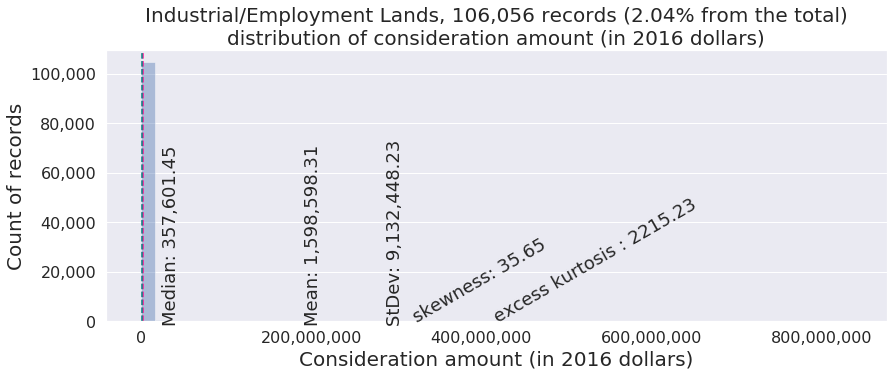

In [51]:
plot_hist(s['price_2016'].dropna(), form_y=True, form_x=True,
          title="{0}, {1:,} records ({2:.2f}% from the total)"
          .format(lu_type, len(s), len(s) / len(df) * 100) + \
          "\ndistribution of consideration amount (in 2016 dollars)",
          x_label="Consideration amount (in 2016 dollars)", 
          mean_xlift=120, med_xlift=70, sdev_xlift=180, skew_xlift=1.1)

#### Add new binary variable and new class to `lu_class`

In [52]:
df.loc[mask1, 'lu_class'] = lu_type
df.loc[mask1, 'luc_industrial'] = True
df['luc_industrial'] = df['luc_industrial'].fillna(False)
df['luc_industrial'].value_counts()

False    5082457
True      106056
Name: luc_industrial, dtype: int64

### Commercial/Shopping
#### Set selection criteria and display distributions of price and count of records per xy coordinate pair

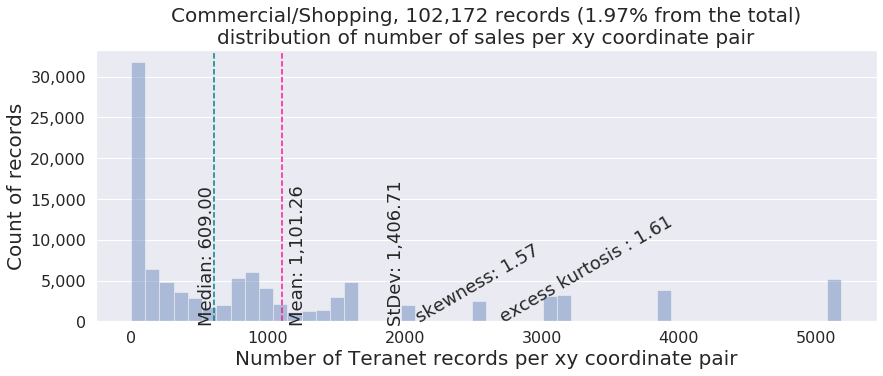

In [53]:
lu_type = 'Commercial/Shopping'
mask1 = df['code'] == lu_type

s = df[mask1]

plot_hist(s['xy_total_sales'], form_y=True, 
          title="{0}, {1:,} records ({2:.2f}% from the total)"
          .format(lu_type, len(s), len(s) / len(df) * 100) + \
          "\ndistribution of number of sales per xy coordinate pair",
          x_label="Number of Teranet records per xy coordinate pair", 
          mean_xlift=1.05, med_xlift=0.8, sdev_xlift=1.7, skew_xlift=1.1)

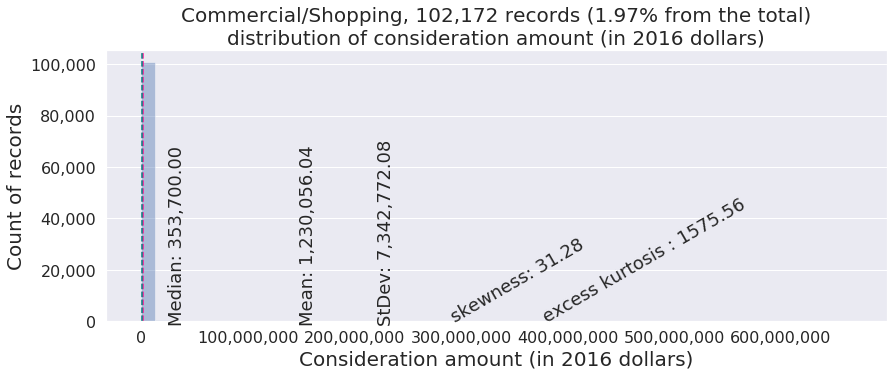

In [54]:
plot_hist(s['price_2016'].dropna(), form_y=True, form_x=True,
          title="{0}, {1:,} records ({2:.2f}% from the total)"
          .format(lu_type, len(s), len(s) / len(df) * 100) + \
          "\ndistribution of consideration amount (in 2016 dollars)",
          x_label="Consideration amount (in 2016 dollars)", 
          mean_xlift=120, med_xlift=70, sdev_xlift=180, skew_xlift=1.3)

#### Add new binary variable and new class to `lu_class`

In [55]:
df.loc[mask1, 'lu_class'] = lu_type
df.loc[mask1, 'luc_commercial'] = True
df['luc_commercial'] = df['luc_commercial'].fillna(False)
df['luc_commercial'].value_counts()

False    5086341
True      102172
Name: luc_commercial, dtype: int64

#### Validate number of records

In [56]:
df['luc_detached'].sum() + df['luc_condo'].sum() + df['luc_strata'].sum() + \
    df['luc_duplex'].sum() + df['luc_townhouse'].sum() + df['luc_mixuse'].sum() + \
    df['luc_mixedcomplex'].sum() + df['luc_industrial'].sum() + df['luc_commercial'].sum()

4371829

In [57]:
df['lu_class'].value_counts().sum()

4525136

In [58]:
df['lu_class'].value_counts()

Single Detached House                          2061867
Apartments/Condos/Residence                    1092568
Strata Townhouses                               312827
Duplex/Semi-Detached                            243151
Townhouse                                       173380
Mix(Commercial Residential)                     167410
Underdeveloped Land                             153307
Mixed Complex (Residential, Office, Retail)     112398
Industrial/Employment Lands                     106056
Commercial/Shopping                             102172
Name: lu_class, dtype: int64

## Encode land use into 3 classes: house, condo and other
Land use classes produced above will be reduced to a 3 class case:
1. Houses (single detached, duplex/semi-detached, townhouses)
2. Condos (apartments/condos, strata townhouses)
3. Everything else (mix use, commercial, industrial, etc.)

New classes will be encoded one-hot and as a single categorical variable.
### Distributions of price

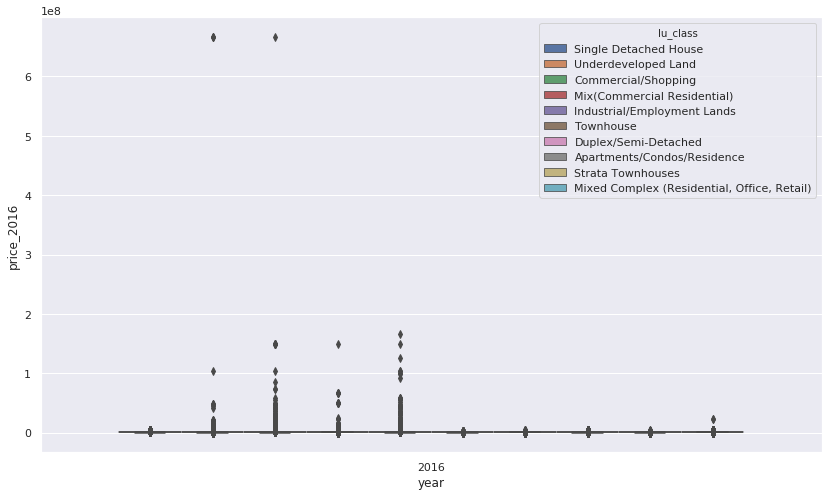

In [59]:
year = 2016
f, ax = plt.subplots(1, figsize=(14, 8))
sns.boxplot(data=df.query('year == @year'), x='year', y='price_2016', hue='lu_class', ax=ax)
plt.show()

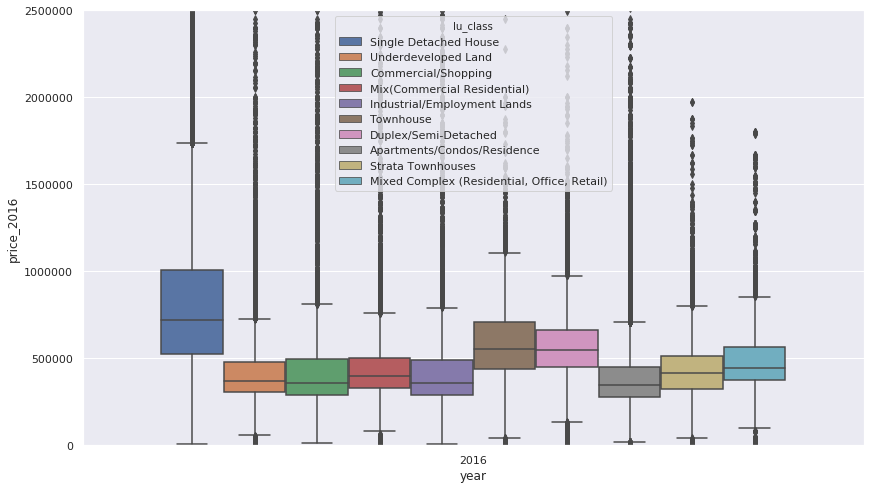

In [60]:
year = 2016
f, ax = plt.subplots(1, figsize=(14, 8))
sns.boxplot(data=df.query('year == @year'), x='year', y='price_2016', hue='lu_class', ax=ax)
ax.set_ylim(0, 2500000)
plt.show()

### Distribtutions of total sales per xy coordinate pair

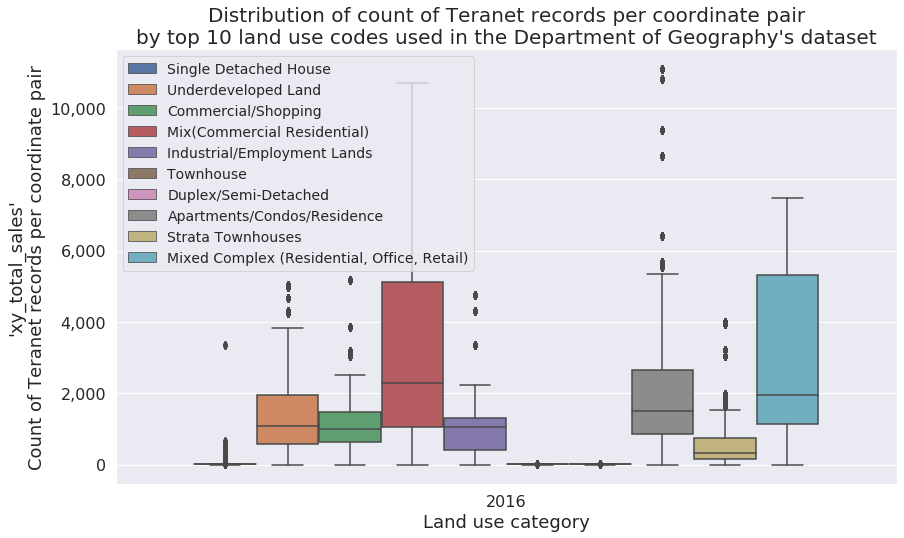

In [64]:
year = 2016
f, ax = plt.subplots(1, figsize=(14, 8))
sns.boxplot(data=df.query('year == @year'), x='year', y='xy_total_sales', hue='lu_class', ax=ax)
ax.set_title("Distribution of count of Teranet records per coordinate pair"
             "\nby top 10 land use codes used in the Department of Geography's dataset", fontsize=20)
ax.set_xlabel("Land use category", fontsize=18)
ax.set_ylabel("'xy_total_sales'\nCount of Teranet records per coordinate pair", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.legend(fontsize=14)
plt.show()

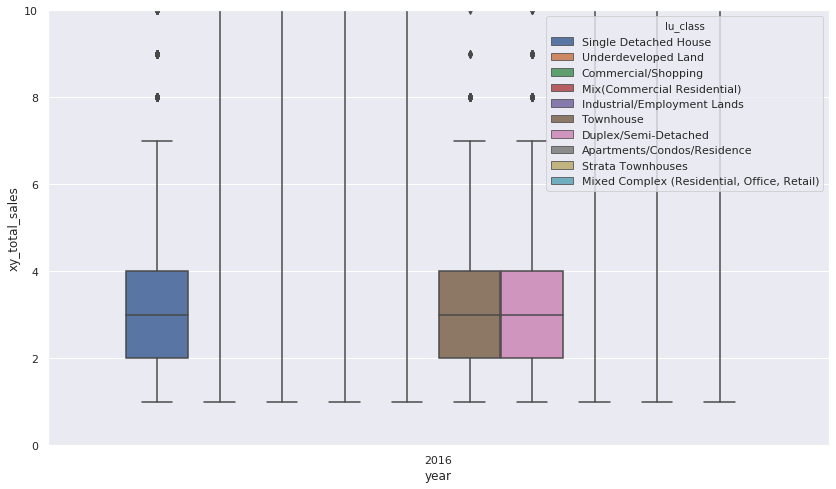

In [62]:
year = 2016
f, ax = plt.subplots(1, figsize=(14, 8))
sns.boxplot(data=df.query('year == @year'), x='year', y='xy_total_sales', hue='lu_class', ax=ax)
ax.set_ylim(0, 10)
plt.show()

### Encode variables into classes
Options tried before:

**Three classes**: "house", "condo", "other"

* house: detached + duplex + townhouse
* condo: condos + strata
* other: everything else

**Four classes**: "detached", "duplex_townhouse", "condo", "other"

* detached: detached
* duplex_townhouse: duplex + townhouse
* condo: condos + strata
* other: everything else

#### Class "house": Single detached houses + Duplex/Semi-Detached + Townhouses

In [63]:
cat_list = ['Single Detached House', 'Duplex/Semi-Detached', 'Townhouse']
mask1 = df['lu_class'].isin(cat_list)
df.loc[mask1, 'lucr_house'] = True
df.loc[mask1, 'lucr'] = 'house'
df['lucr_house'] = df['lucr_house'].fillna(False)
df['lucr_house'].value_counts()

False    2710115
True     2478398
Name: lucr_house, dtype: int64

#### Category "condo": apartments/condos and strata townhouses

In [64]:
cat_list = ['Apartments/Condos/Residence', 'Strata Townhouses']
mask1 = df['lu_class'].isin(cat_list)
df.loc[mask1, 'lucr_condo'] = True
df.loc[mask1, 'lucr'] = 'condo'
df['lucr_condo'] = df['lucr_condo'].fillna(False)
df['lucr_condo'].value_counts()

False    3783118
True     1405395
Name: lucr_condo, dtype: int64

#### Category "other": mixed, commercial, industrial and all other development types

In [65]:
mask1 = df['lucr_house'] == False
mask2 = df['lucr_condo'] == False
df.loc[mask1 & mask2, 'lucr_other'] = True
df.loc[mask1 & mask2, 'lucr'] = 'other'
df['lucr_other'] = df['lucr_other'].fillna(False)
df['lucr_other'].value_counts()

False    3883793
True     1304720
Name: lucr_other, dtype: int64

#### Count of Teranet records by reduced land use category

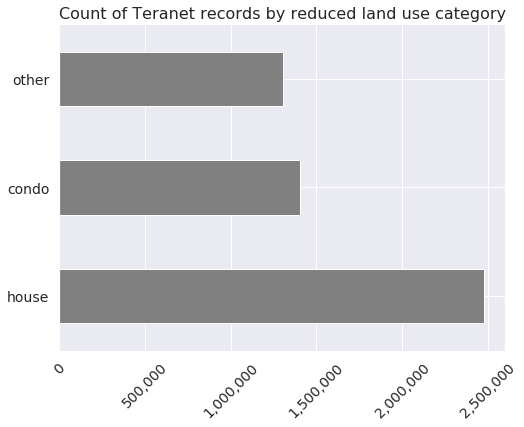

In [66]:
f, ax = plt.subplots(1, figsize=(8, 6))
df['lucr'].value_counts().plot(kind='barh', ax=ax, color='gray')
ax.get_xaxis().set_major_formatter(
            matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_title("Count of Teranet records by reduced land use category", fontsize=16)
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)
plt.show()

## Train a classification algorithm and add a new column `lucr_predict`
Census variables, along with the new Teranet features, are used by a machine learning algorithm to classify land use from Teranet and Census data; then Census variables are removed from the final Teranet dataset, and the new column `lucr_predict` is added to each Teranet records. 

This new attribute represents reduced land use class ("house", "condo", or "other"), as predicted by a machine learning algorithm trained on the housing market dynamics, as seen by Census data and new Teranet features.

### Temporarily join all select Census and TTS variables
All select Census and TTS variables are temporarily joined to Teranet records (by `dauid` and `census2001_year` and by `taz_o` and `tts_year`).

#### Load Census data

In [67]:
census_path = data_path + 'census/'
os.listdir(census_path)

['da_census_income.csv',
 'Census data availability.xlsx',
 'da_census.xls',
 'da_census_select_tidy.csv',
 'da_census_income_shapefile',
 'da_census_select.csv']

In [68]:
census_df = df_from_csv(census_path + 'da_census_select_tidy.csv')

----- DataFrame loaded
in 0.20 seconds
with 36,728 rows
and 32 columns
-- Column names:
 Index(['DAUID', 'year', 'Avg_HHsize', 'Avg_HHinc', 'Avg_own_payt',
       'Avg_val_dwel', 'Avg_rent', 'Pop', 'PopDens', 'Dwel', 'DwelDens',
       'Sgl_det', 'Apt_5plus', 'Sgl_att', 'Owned', 'Rented', 'CarTrVan_d',
       'CarTrVan_p', 'PT', 'Walk', 'Bike', 'Lbrfrc', 'Emp', 'Unemp',
       'Not_lbrfrc', 'Employee', 'Self_emp', 'At_home', 'No_fix_wkpl',
       'Usl_wkpl', 'Blue_cljob', 'White_cljob'],
      dtype='object')


#### Load TTS data

In [69]:
tts_path = data_path + 'tts/'
os.listdir(tts_path)

['tts_num_jobs_tidy.csv',
 'TAZ_2001shp.zip',
 'TAZ_2001shp',
 'taz_tts_tidy.csv',
 'taz_info.csv',
 'TTS_variables.xlsx',
 'taz_tts.xlsx',
 'Num_of_Jobs.xlsx']

In [70]:
tts_df = df_from_csv(tts_path + 'taz_tts_tidy.csv')

----- DataFrame loaded
in 0.01 seconds
with 12,012 rows
and 8 columns
-- Column names:
 Index(['TAZ_O', 'year', 'Pop', 'FT_wrk', 'Stu', 'HH', 'Jobs', 'Cars'], dtype='object')


#### Join Census data to Teranet data

In [71]:
t = time()
df = pd.merge(df, census_df, how='left',
              left_on=['dauid', 'census2001_year'], right_on=['DAUID', 'year'])
df = df.drop(['DAUID', 'year_y'], axis=1).rename(columns={'year_x': 'year'})
elapsed = time() - t

print("----- Census variables were joined to the DataFrame"
      "\nin {0:,.2f} seconds ({1:.2f} minutes)".format(elapsed, elapsed / 60) + 
      "\nwith {0:,} rows\nand {1:,} columns"
      .format(df.shape[0], df.shape[1]) + 
      "\n-- Column names:\n", df.columns)

----- Census variables were joined to the DataFrame
in 54.48 seconds (0.91 minutes)
with 5,188,513 rows
and 108 columns
-- Column names:
 Index(['transaction_id', 'lro_num', 'pin', 'consideration_amt',
       'registration_date', 'postal_code', 'unitno', 'street_name',
       'street_designation', 'street_direction',
       ...
       'Emp', 'Unemp', 'Not_lbrfrc', 'Employee', 'Self_emp', 'At_home',
       'No_fix_wkpl', 'Usl_wkpl', 'Blue_cljob', 'White_cljob'],
      dtype='object', length=108)


#### Join TTS data to Teranet data

In [72]:
t = time()
df = pd.merge(df, tts_df, how='left',
              left_on=['taz_o', 'tts_year'], right_on=['TAZ_O', 'year'])
df = df.drop(['TAZ_O', 'year_y'], axis=1).rename(columns={'year_x': 'year'})
elapsed = time() - t
print("----- TTS variables were joined to the DataFrame"
      "\nin {0:,.2f} seconds ({1:.2f} minutes)".format(elapsed, elapsed / 60) + 
      "\nwith {0:,} rows\nand {1:,} columns"
      .format(df.shape[0], df.shape[1]) + 
      "\n-- Column names:\n", df.columns)

----- TTS variables were joined to the DataFrame
in 61.74 seconds (1.03 minutes)
with 5,188,513 rows
and 114 columns
-- Column names:
 Index(['transaction_id', 'lro_num', 'pin', 'consideration_amt',
       'registration_date', 'postal_code', 'unitno', 'street_name',
       'street_designation', 'street_direction',
       ...
       'No_fix_wkpl', 'Usl_wkpl', 'Blue_cljob', 'White_cljob', 'Pop_y',
       'FT_wrk', 'Stu', 'HH', 'Jobs', 'Cars'],
      dtype='object', length=114)


### Take a train-test and two validation subsets from Teranet records
Subset of Teranet records from 2012 is used to train and test a machine learning algorithm classifying the three reduced categories of land use ("house", "condo" or "other"), as derived in this notebook from the detailed land use provided by the Department of Geography.

Subsets of Teranet records from 2011 and 2013 are used to validate algorithm's predictions.

In [73]:
year_train_test_min = 2011
year_train_test_max = 2014

year_val1 = 2010
year_val2 = 2015

s = df.query('year >= @year_train_test_min & year <= @year_train_test_max')
s_val1 = df.query('year == @year_val1')
s_val2 = df.query('year == @year_val2')

print("{0:,} Teranet records in the train-test subset (records from {1} to {2})."
      .format(len(s), year_train_test_min, year_train_test_max))
print("{0:,} Teranet records in the validation subset #1 (records from {1}).".format(len(s_val1), year_val1))
print("{0:,} Teranet records in the validation subset #2 (records from {1}).".format(len(s_val2), year_val2))

857,896 Teranet records in the train-test subset (records from 2011 to 2014).
216,492 Teranet records in the validation subset #1 (records from 2010).
244,787 Teranet records in the validation subset #2 (records from 2015).


### Select features and fill missing values, `top15f` feature subset

In [74]:
top15f = ['xy_total_sales', 'xy_prev_sales', 'xy_first_sale',
          'xy_years_since_last_sale', 'xy_years_to_next_sale', 'xy_price_cum_sum',
          'med_price_xy', 'Avg_rent', 'PopDens', 'Dwel', 'DwelDens', 'Sgl_det',
          'Apt_5plus', 'Not_lbrfrc', 'Jobs',
          'lucr_house', 'lucr_condo', 'lucr_other', 'lucr']
s = s[top15f]
s_val1 = s_val1[top15f]
s_val2 = s_val2[top15f]
s.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 857896 entries, 0 to 5002104
Data columns (total 19 columns):
xy_total_sales              857896 non-null int64
xy_prev_sales               857896 non-null int64
xy_first_sale               857896 non-null bool
xy_years_since_last_sale    746796 non-null float64
xy_years_to_next_sale       575944 non-null float64
xy_price_cum_sum            857896 non-null float64
med_price_xy                857896 non-null float64
Avg_rent                    855435 non-null float64
PopDens                     857896 non-null float64
Dwel                        855523 non-null float64
DwelDens                    857896 non-null float64
Sgl_det                     855523 non-null float64
Apt_5plus                   855523 non-null float64
Not_lbrfrc                  855435 non-null float64
Jobs                        857832 non-null float64
lucr_house                  857896 non-null bool
lucr_condo                  857896 non-null bool
lucr_other       

In [75]:
col1 = 'xy_years_to_next_sale'
col2 = 'xy_years_since_last_sale'
mask1 = s[col1].isnull()
print("For records with missing '{0}', values of '{1}' are: mean={2:,.2f}, median={3:,.2f}"
      .format(col1, col2, s.loc[mask1, col2].mean(), s.loc[mask1, col2].median()))
mask1 = s[col2].isnull()
print("For records with missing '{0}', values of '{1}' are: mean={2:,.2f}, median={3:,.2f}"
      .format(col2, col1, s.loc[mask1, col1].mean(), s.loc[mask1, col1].median()))

For records with missing 'xy_years_to_next_sale', values of 'xy_years_since_last_sale' are: mean=7.72, median=6.02
For records with missing 'xy_years_since_last_sale', values of 'xy_years_to_next_sale' are: mean=2.02, median=1.69


In [76]:
# missing year to next sale is replaced with median year since last sale and vice versa
mask1 = s[col1].isnull()
s.loc[mask1, col1] = s.loc[mask1, col2].median()
mask1 = s_val1[col1].isnull()
s_val1.loc[mask1, col1] = s_val1.loc[mask1, col2].median()
mask1 = s_val2[col1].isnull()
s_val2.loc[mask1, col1] = s_val2.loc[mask1, col2].median()

mask1 = s[col2].isnull()
s.loc[mask1, col2] = s.loc[mask1, col1].median()
mask1 = s_val1[col2].isnull()
s_val1.loc[mask1, col2] = s_val1.loc[mask1, col1].median()
mask1 = s_val2[col2].isnull()
s_val2.loc[mask1, col2] = s_val2.loc[mask1, col1].median()

s.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 857896 entries, 0 to 5002104
Data columns (total 19 columns):
xy_total_sales              857896 non-null int64
xy_prev_sales               857896 non-null int64
xy_first_sale               857896 non-null bool
xy_years_since_last_sale    857896 non-null float64
xy_years_to_next_sale       857896 non-null float64
xy_price_cum_sum            857896 non-null float64
med_price_xy                857896 non-null float64
Avg_rent                    855435 non-null float64
PopDens                     857896 non-null float64
Dwel                        855523 non-null float64
DwelDens                    857896 non-null float64
Sgl_det                     855523 non-null float64
Apt_5plus                   855523 non-null float64
Not_lbrfrc                  855435 non-null float64
Jobs                        857832 non-null float64
lucr_house                  857896 non-null bool
lucr_condo                  857896 non-null bool
lucr_other       

In [77]:
s = s.dropna()
s_val1 = s_val1.dropna()
s_val2 = s_val2.dropna()
print("{0:,} rows in train-test subset, {1:,} rows in validation subset #1, {2:,} rows in validation subset #2"
      .format(len(s), len(s_val1), len(s_val2)))

855,314 rows in train-test subset, 216,140 rows in validation subset #1, 244,400 rows in validation subset #2


In [78]:
target_cols = 4
feat_cols = s.columns[:-target_cols]
feat_cols

Index(['xy_total_sales', 'xy_prev_sales', 'xy_first_sale',
       'xy_years_since_last_sale', 'xy_years_to_next_sale', 'xy_price_cum_sum',
       'med_price_xy', 'Avg_rent', 'PopDens', 'Dwel', 'DwelDens', 'Sgl_det',
       'Apt_5plus', 'Not_lbrfrc', 'Jobs'],
      dtype='object')

### Encode target

In [79]:
le = LabelEncoder()

s['lucr_e'] = le.fit_transform(s['lucr'])
s_val1['lucr_e'] = le.transform(s_val1['lucr'])
s_val2['lucr_e'] = le.transform(s_val2['lucr'])

print(s['lucr'].value_counts().sort_index())
print(s['lucr_e'].value_counts().sort_index())
print(s_val1['lucr'].value_counts().sort_index())
print(s_val1['lucr_e'].value_counts().sort_index())
print(s_val2['lucr'].value_counts().sort_index())
print(s_val2['lucr_e'].value_counts().sort_index())

s = s.drop(['lucr', 'lucr_house', 'lucr_condo', 'lucr_other'], axis=1)
s_val1 = s_val1.drop(['lucr', 'lucr_house', 'lucr_condo', 'lucr_other'], axis=1)
s_val2 = s_val2.drop(['lucr', 'lucr_house', 'lucr_condo', 'lucr_other'], axis=1)
print("Land use encoded!")

condo    222904
house    288829
other    343581
Name: lucr, dtype: int64
0    222904
1    288829
2    343581
Name: lucr_e, dtype: int64
condo    66944
house    77482
other    71714
Name: lucr, dtype: int64
0    66944
1    77482
2    71714
Name: lucr_e, dtype: int64
condo     57424
house     76782
other    110194
Name: lucr, dtype: int64
0     57424
1     76782
2    110194
Name: lucr_e, dtype: int64
Land use encoded!


### Select features and target

In [80]:
target_col = 'lucr_e'

X = s[feat_cols].values
y = s[target_col].values
X_val1 = s_val1[feat_cols].values
y_val1 = s_val1[target_col].values
X_val2 = s_val2[feat_cols].values
y_val2 = s_val2[target_col].values

print("Features and target selected.")

Features and target selected.


### Perform the train-test split

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)
print("Performed train-test split.")
print('Labels counts in y:', np.bincount(y))
print('Labels counts in y_train:', np.bincount(y_train))
print('Labels counts in y_test:', np.bincount(y_test))
print('Labels counts in y_val1:', np.bincount(y_val1))
print('Labels counts in y_val2:', np.bincount(y_val2))

Performed train-test split.
Labels counts in y: [222904 288829 343581]
Labels counts in y_train: [156033 202180 240506]
Labels counts in y_test: [ 66871  86649 103075]
Labels counts in y_val1: [66944 77482 71714]
Labels counts in y_val2: [ 57424  76782 110194]


### Train and test classification algorithms

In [82]:
model_name = 'Logistic regression (raw features)'
lr = LogisticRegression(C=100.0, random_state=1, solver='lbfgs', multi_class='auto', max_iter=50)
fit_model(lr, model_name, X_train, y_train, X_test, y_test, X_val1, y_val1, X_val2, y_val2)

/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)



Logistic regression (raw features) fit, took 23.07 seconds (0.38 minutes)
accuracy: train=0.38, test=0.38, validation #1=0.32, validation #2=0.43


In [83]:
model_name = 'Random Forest'
forest = RandomForestClassifier(criterion='gini', n_estimators=25, random_state=1, n_jobs=8)
fit_model(forest, model_name, X_train, y_train, X_test, y_test, X_val1, y_val1, X_val2, y_val2)


Random Forest fit, took 15.07 seconds (0.25 minutes)
accuracy: train=1.00, test=0.97, validation #1=0.95, validation #2=0.87


### Add new column `lucr_predict` to Teranet records

#### Temporarily fill missing values for `xy_years_to_next_sale` and `xy_years_since_last_sale`

In [84]:
col1 = 'xy_years_to_next_sale'
col2 = 'xy_years_since_last_sale'
mask_col1_nan = df[col1].isnull()
print("For records with missing '{0}', values of '{1}' are: mean={2:,.2f}, median={3:,.2f}"
      .format(col1, col2, df.loc[mask_col1_nan, col2].mean(), df.loc[mask_col1_nan, col2].median()))
mask_col2_nan = df[col2].isnull()
print("For records with missing '{0}', values of '{1}' are: mean={2:,.2f}, median={3:,.2f}"
      .format(col2, col1, df.loc[mask_col2_nan, col1].mean(), df.loc[mask_col2_nan, col1].median()))

For records with missing 'xy_years_to_next_sale', values of 'xy_years_since_last_sale' are: mean=6.99, median=5.16
For records with missing 'xy_years_since_last_sale', values of 'xy_years_to_next_sale' are: mean=7.46, median=5.55


In [85]:
# missing year to next sale is replaced with median year since last sale and vice versa
df.loc[mask_col1_nan, col1] = df.loc[mask_col1_nan, col2].median()
df.loc[mask_col2_nan, col2] = df.loc[mask_col2_nan, col1].median()
print("Missing values temporarily filled with median for the other column to generate input vectors.")

Missing values temporarily filled with median for the other column to generate input vectors.


In [86]:
t = time()

forest = RandomForestClassifier(criterion='gini', n_estimators=25, random_state=random_state, n_jobs=8)
forest.fit(X, y)

mask1 = df[feat_cols].notnull().all(axis=1)
df.loc[mask1, 'lucr_predict'] = forest.predict(df.loc[mask1, feat_cols].values)

elapsed = time() - t
print("New column 'lucr_predict' was added to the DataFrame. Took {0:,.2f} seconds ({1:,.2f} minutes)."
      .format(elapsed, elapsed / 60))

New column 'lucr_predict' was added to the DataFrame. Took 27.86 seconds (0.46 minutes).


In [87]:
df.loc[mask_col1_nan, col1] = np.nan
df.loc[mask_col2_nan, col2] = np.nan
print("Values have been reset back to missing.")

Values have been reset back to missing.


In [88]:
labels = {x: le.inverse_transform([x])[0] for x in range(len(le.classes_))}
df['lucr_predict'] = df['lucr_predict'].map(labels)
print("`lucr_predict` was mapped with target labels.")

`lucr_predict` was mapped with target labels.


In [89]:
mask1 = df['lucr_predict'].isnull()
df.loc[~mask1, 'lucr'].value_counts().sort_index()

condo    1094792
house    1770890
other    1119693
Name: lucr, dtype: int64

In [90]:
df['lucr_predict'].value_counts().sort_index()

condo    1093344
house    1715695
other    1176336
Name: lucr_predict, dtype: int64

## Save results to a new .csv file
Teranet dataset without NaN records and with new columns is saved as:
`data/HHSaleHistory_cleaned_v0.9_GTHA_DA_with_cols_v0.9.csv`

In [91]:
df = df.drop(['Avg_HHsize', 'Avg_HHinc', 'Avg_own_payt',
              'Avg_val_dwel', 'Avg_rent', 'Pop_x', 'PopDens', 'Dwel', 'DwelDens',
              'Sgl_det', 'Apt_5plus', 'Sgl_att', 'Owned', 'Rented', 'CarTrVan_d',
              'CarTrVan_p', 'PT', 'Walk', 'Bike', 'Lbrfrc', 'Emp', 'Unemp',
              'Not_lbrfrc', 'Employee', 'Self_emp', 'At_home', 'No_fix_wkpl',
              'Usl_wkpl', 'Blue_cljob', 'White_cljob', 'Pop_y', 'FT_wrk', 'Stu', 'HH',
              'Jobs', 'Cars'], axis=1)
df.columns

Index(['transaction_id', 'lro_num', 'pin', 'consideration_amt',
       'registration_date', 'postal_code', 'unitno', 'street_name',
       'street_designation', 'street_direction', 'municipality',
       'street_number', 'x', 'y', 'dauid', 'csduid', 'csdname', 'taz_o', 'fsa',
       'pca_id', 'postal_code_dmti', 'pin_lu', 'landuse', 'prop_code',
       'dmti_lu', 'street_name_raw', 'year', 'year_month', 'year3',
       'census_year', 'census2001_year', 'tts_year', 'tts1991_year', 'xy',
       'pin_total_sales', 'xy_total_sales', 'pin_prev_sales', 'xy_prev_sales',
       'xy_first_sale', 'pin_years_since_last_sale',
       'xy_years_since_last_sale', 'xy_years_to_next_sale',
       'da_days_since_last_sale', 'da_years_since_last_sale',
       'xy_sale_next_6m', 'price_2016', 'pin_price_cum_sum',
       'xy_price_cum_sum', 'pin_price_pct_change', 'xy_price_pct_change',
       'price_da_pct_change', 'med_price_xy', 'med_price_year',
       'price_to_med_xy', 'price_to_med_year', 'outlier_

In [92]:
save_path = teranet_path + '4_Teranet_lu_predict_3c.csv'
t = time()
df.to_csv(save_path, index=False)
elapsed = time() - t
print("DataFrame saved to file:\n", save_path,
      "\ntook {0:.2f} seconds ({1:.2f} minutes).".format(elapsed, elapsed / 60))

DataFrame saved to file:
 ../../data/teranet/4_Teranet_lu_predict_3c.csv 
took 480.63 seconds (8.01 minutes).
